In [151]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
from scipy.optimize import curve_fit
from typing import Union, Tuple, List, Dict
from nanonets.utils import load_boolean_results, fitness, abundance, get_best_logic_gate, nonlinear_parameter, return_ndr, return_nls

%matplotlib inline
plt.style.use(["science","bright","grid"])

# data_folder = "/home/jonasmensing/bagheera/data/1_funding_period/system_size/"
data_folder = "/home/j/j_mens07/bagheera/data/1_funding_period/system_size/"
GATES       = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
plt.style.use(["science","bright","grid"])

def abundance_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR'], 
    dpi: int = 200, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [1.0, 100], 
    xlabel: str = 'Fitness', ylabel: str = 'Abundance', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)
        # fig.set_figheight(fig.get_figheight()*1.1)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax.plot(df[f'{gate} Fitness'], df[f'{gate} Fitness Abundance'], color=cmap(j/N_vals))
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel, fontsize='large')
            else:
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel, fontsize='large')
            else:
                ax.set_yticklabels("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys)**2, vmax=np.max(keys)**2)
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$N_{NP}$')

    return fig, ax

def density_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR'], 
    dpi: int = 200, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [0, 2], 
    xlabel: str = 'Fitness', ylabel: str = 'Density', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax = sns.kdeplot(data=df[f'{gate} Fitness'], color=cmap(j/N_vals), log_scale=True, ax=ax)
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel, fontsize='large')
            else:
                ax.set_xlabel("")
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel, fontsize='large')
            else:
                # ax.set_yticklabels("")
                ax.set_ylabel("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys)**2, vmax=np.max(keys)**2)
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$N_{NP}$')

    return fig, ax

In [152]:
# Parameter
N_min   = 3
N_max   = 16
N_keys  = N_max-N_min+1
N_vals  = [i for i in range(N_min,N_max+1)]
N_e     = 8
delta   = 0.0

data            = load_boolean_results(folder=data_folder, N=N_vals, N_e=N_e, input_cols=['E1','E3'], max_error=0.1)
fitness_data    = {N : fitness(df=data[N], input_cols=['E1','E3'], delta=delta) for N in N_vals}
abundance_data  = {N : abundance(df=fitness_data[N]) for N in N_vals}
U_on            = [data[N].loc[:,'E1'].max() for N in N_vals]

In [153]:
for N in N_vals:
    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*1.5)
    for i, gate in enumerate(GATES):
        ax = fig.add_subplot(2,3,i+1)
        best_gate = get_best_logic_gate(data[N], fitness_data[N], gate)
        ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
        ax.set_xticks([0,1,2,3])
        # ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
        ax.set_xticklabels(["0/0","0/1","1/0","1/1"], fontsize='large')
        ax.set_title(gate)
        ax.set_yticklabels("")
        
        if i % 3 == 0:
            ax.set_ylabel("Output", fontsize='large')
            # ax.set_ylabel("$I$ [pA]")

    fig.savefig(f"plots/system_size/best_gates/N_{N}.svg", transparent=True)
    fig.savefig(f"plots/system_size/best_gates/N_{N}.pdf", transparent=True)
    plt.close(fig)

### Box Plots

In [154]:
fitness_melted = pd.DataFrame()
for gate in GATES:
    df              = pd.DataFrame([fitness_data[key].loc[:,f'{gate} Fitness'].copy().values for key in N_vals],index=np.array(N_vals)**2).T
    df              = df.melt(var_name='$N_{NP}$', value_name='$Fitness$').dropna().reset_index(drop=True)
    df['Gate']      = gate
    fitness_melted  = pd.concat([fitness_melted,df]).reset_index(drop=True)
fitness_melted

,$N_{NP}$,$Fitness$,Gate
0,9,2.882219,AND
1,9,2.184065,AND
2,9,3.194784,AND
3,9,1.667409,AND
4,9,6.456490,AND
...,...,...,...
1633141,256,-1.457756,NOR
1633142,256,-2.240070,NOR
1633143,256,-2.420151,NOR
1633144,256,-2.415797,NOR


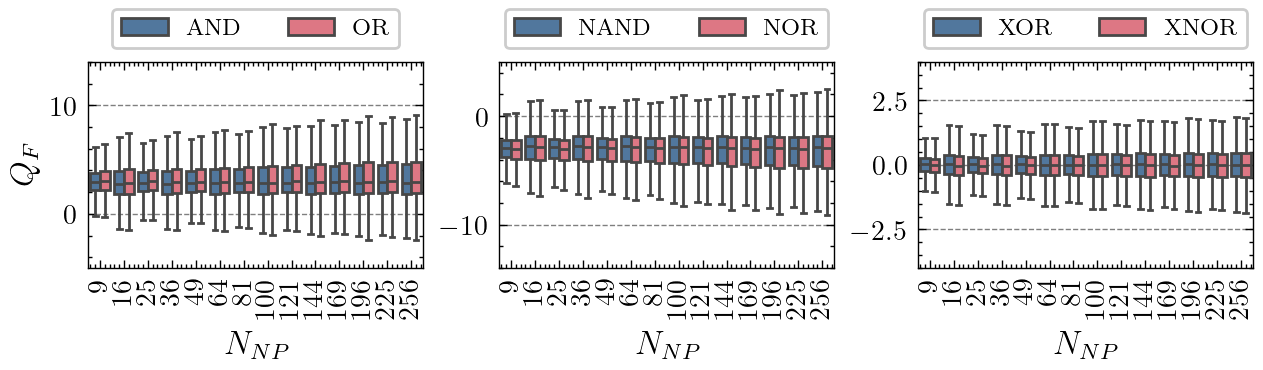

In [155]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*0.7)
fig.set_figwidth(fig.get_figwidth()*1.8)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):
    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']==g_comb[0])|(fitness_melted['Gate']==g_comb[1])],
                      x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0.)
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("$Q_F$", fontsize='large')
    if i == 0:
        ax.set_ylim(-5,14)
    elif i == 1:
        ax.set_ylim(-14,5)
    else:
        ax.set_ylim(-4,4)
    plt.xticks(rotation=90)
    ax.set_xlabel("$N_{NP}$", fontsize='large')

fig.savefig("plots/system_size/box_plots.svg", transparent=True)
fig.savefig("plots/system_size/box_plots.pdf", transparent=True)

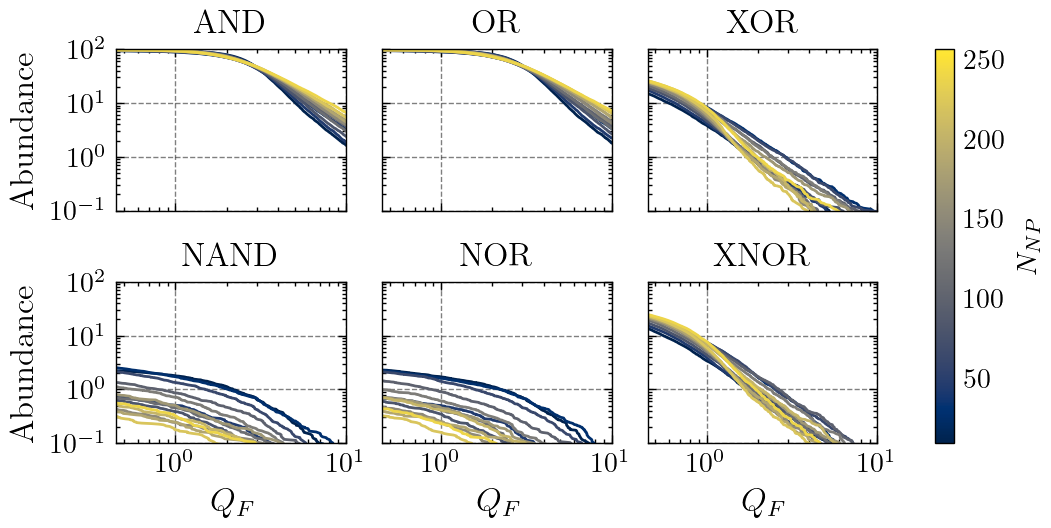

In [156]:
fig, ax = abundance_multiplot(abundance_data, xlabel='$Q_F$', y_limits=[0.1,100])
fig.savefig("plots/system_size/abundance_gate_comp.svg", transparent=True)
fig.savefig("plots/system_size/abundance_gate_comp.pdf", transparent=True)

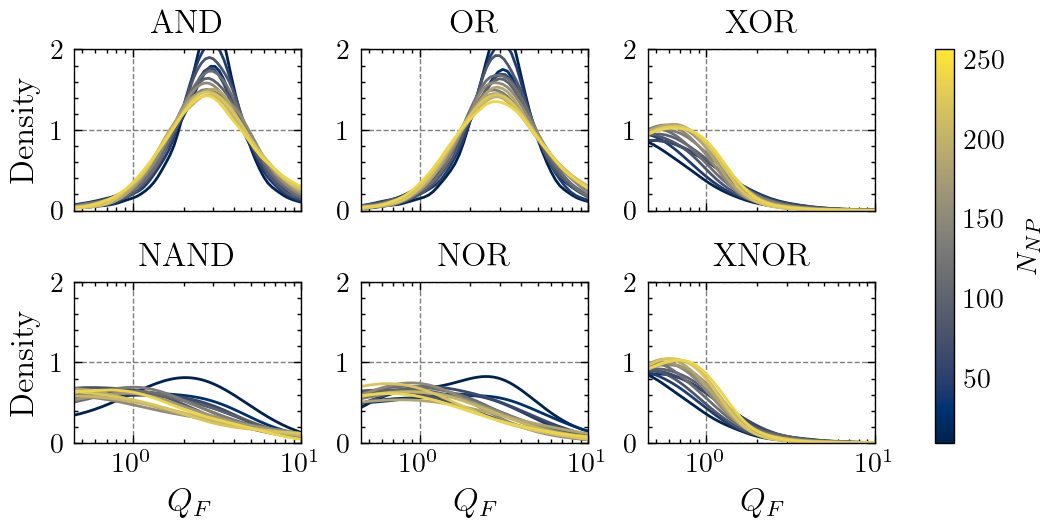

In [157]:
fig, ax = density_multiplot(abundance_data, xlabel='$Q_F$')
fig.savefig("plots/system_size/density_gate_comp.svg", transparent=True)
fig.savefig("plots/system_size/density_gate_comp.pdf", transparent=True)

## Nonlinear Parameter

In [158]:
# Current Relations
n_bootstrap = 100
params      = {N : nonlinear_parameter(data[N], on_state=U_on[i], n_bootstrap=n_bootstrap) for i, N in enumerate(N_vals)}

# NDR / NLS
bins    = 'fd'
Q_ndr   = []
Q_nls   = []
for i in range(n_bootstrap): 

    Q_ndr_l =   np.array([return_ndr(params[N][i]['Ml']) for N in N_vals])
    Q_ndr_r =   np.array([return_ndr(params[N][i]['Mr']) for N in N_vals])
    Q_ndr.append((Q_ndr_l + Q_ndr_r) / 2)

    Q_nls.append(np.array([return_nls(df=params[N][i], bins=bins) for N in N_vals]))

[-0.11166383  0.10757542]
[0.18235982 0.10883281]
[ 0.015904    7.00758187 -3.84932436  0.0437792 ]
[0.02722246 3.93981207 3.79333598 0.05213231]


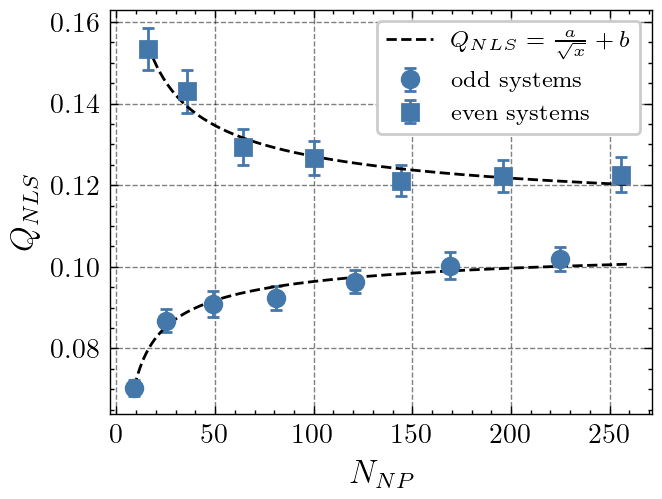

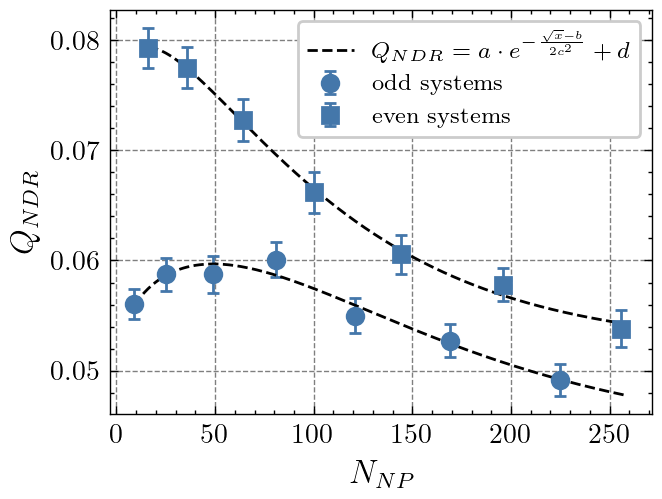

In [159]:
def inv_sq_model(x, a, b):
    return b + a/np.sqrt(x)
def gauss_model(x, a, b, c, d):
    return d + a*np.exp(-((np.sqrt(x)-b)**2) / ((2*c)**2))

x_fit_odd   = np.arange(9,260)
x_fit_even  = np.arange(16,260)

even_vals   = (np.array(N_vals).copy()[1::2])**2
odd_vals    = (np.array(N_vals).copy()[::2])**2
Q_ndr_even  = np.array(Q_ndr).copy()[:,1::2]
Q_ndr_odd   = np.array(Q_ndr).copy()[:,::2]
Q_nls_even  = np.array(Q_nls).copy()[:,1::2]
Q_nls_odd   = np.array(Q_nls).copy()[:,::2]

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    p = ax.errorbar(odd_vals, np.mean(Q_nls_odd,axis=0), 1.96*np.std(Q_nls_odd,axis=0), marker='o', label='odd systems', ls='', capsize=2)
    pf, cov = curve_fit(inv_sq_model, odd_vals, np.mean(Q_nls_odd,axis=0))
    ax.plot(x_fit_odd, inv_sq_model(x_fit_odd,*pf), color='black', ls='--')
    print(pf)

    ax.errorbar(even_vals, np.mean(Q_nls_even,axis=0), 1.96*np.std(Q_nls_even,axis=0), marker='s', label='even systems', color=p[0].get_color(), ls='', capsize=2)
    pf, cov = curve_fit(inv_sq_model, even_vals, np.mean(Q_nls_even,axis=0))
    ax.plot(x_fit_even, inv_sq_model(x_fit_even,*pf), color='black', ls='--', label='$Q_{NLS} = \\frac{a}{\\sqrt{x}} + b$')
    print(pf)

    ax.set_xlabel('$N_{NP}$', fontsize='large')
    ax.legend(loc='upper right', fontsize='small')
    ax.set_ylabel("$Q_{NLS}$", fontsize='large')
fig.savefig("plots/system_size_scaled/q_nls_vs_size.svg", transparent=True)
fig.savefig("plots/system_size_scaled/q_nls_vs_size.pdf", transparent=True)

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    p = ax.errorbar(odd_vals, np.mean(Q_ndr_odd,axis=0), 1.96*np.std(Q_ndr_odd,axis=0), marker='o', label='odd systems', ls='', capsize=2)
    pf, cov = curve_fit(gauss_model, odd_vals, np.mean(Q_ndr_odd,axis=0), p0=[0.01,7,5.3,0.04])
    ax.plot(x_fit_odd, gauss_model(x_fit_odd,*pf), color='black', ls='--')
    print(pf)

    ax.errorbar(even_vals, np.mean(Q_ndr_even,axis=0), 1.96*np.std(Q_ndr_even,axis=0), marker='s', label='even systems', color=p[0].get_color(), ls='', capsize=2)
    pf, cov = curve_fit(gauss_model, even_vals, np.mean(Q_ndr_even,axis=0), p0=[0.01,7,5.3,0.04])
    ax.plot(x_fit_even, gauss_model(x_fit_even,*pf), color='black', ls='--', label='$Q_{NDR} = a \\cdot e^{-\\frac{\\sqrt{x}-b}{2c^2}} + d$')
    print(pf)

    ax.set_xlabel('$N_{NP}$', fontsize='large')
    ax.legend(loc='upper right', fontsize='small')
    ax.set_ylabel("$Q_{NDR}$", fontsize='large')

fig.savefig("plots/system_size_scaled/q_ndr_vs_size.svg", transparent=True)
fig.savefig("plots/system_size_scaled/q_ndr_vs_size.pdf", transparent=True)

In [160]:
# N_plots = [3,5,7,11,13,15]
# gates   = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
# marker  = ['o','s','^','v','<','>']
# fig     = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*1.5)
# fig.set_figheight(fig.get_figheight()*1.1)

# for i, N in enumerate(N_plots):

#     ax  = plt.subplot(2,3,i+1)
#     for j, gate in enumerate(gates):
#         ax.plot(abundance_data[N][f'{gate} Fitness'], abundance_data[N][f'{gate} Fitness Abundance'], label=gate, marker=marker[j % len(marker)], markevery=0.1)
    
#     ax.set_xlim(0.45, 10)
#     ax.set_ylim(1.0, 100)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_title('$N_{NP} = '+f'{N*N}$')
    
#     if i % 3 == 0:
#         ax.set_ylabel("Abundance")
#     else:
#         ax.set_yticklabels("")
#     if i > 2:
#         ax.set_xlabel("Fitness")
#     else:
#         ax.set_xticklabels("")
    
#     if i==0:
#         leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.35), ncol=6, fontsize='small')

# leg.set_in_layout(False)
# fig.canvas.draw()
# leg.set_in_layout(True)
# fig.set_layout_engine('none')
# fig.savefig("plots/system_size_scaled/abundance_size_comp.svg", transparent=True)

In [ ]:
# def inv_sq_model(x, a, b):
#     return b + a/np.sqrt(x)

# x_fit = np.arange(5,260)

# even_vals   = (np.array(N_vals).copy()[1::2])**2
# odd_vals    = (np.array(N_vals).copy()[::2])**2
# Q_ndr_even  = np.array(Q_ndr).copy()[:,1::2]
# Q_ndr_odd   = np.array(Q_ndr).copy()[:,::2]
# Q_nls_even  = np.array(Q_nls).copy()[:,1::2]
# Q_nls_odd   = np.array(Q_nls).copy()[:,::2]

# with plt.style.context(["science","bright","grid"]):

#     fig = plt.figure(dpi=200)
#     ax  = fig.add_subplot()
    
#     # ax.errorbar(np.array(N_vals)**2, np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='NDR')
#     # ax.errorbar(np.array(N_vals)**2, np.mean(Q_nls,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='s', label='NLS')

#     p = ax.errorbar(odd_vals, np.mean(Q_ndr_odd,axis=0), 1.96*np.std(Q_ndr_odd,axis=0), marker='o', label='NDR')
#     ax.errorbar(even_vals, np.mean(Q_ndr_even,axis=0), 1.96*np.std(Q_ndr_even,axis=0), marker='s', label='NLS', color=p[0].get_color())

#     p = ax.errorbar(odd_vals, np.mean(Q_nls_odd,axis=0), 1.96*np.std(Q_nls_odd,axis=0), marker='o', label='NDR', ls='')
#     pf, cov = curve_fit(inv_sq_model, odd_vals, np.mean(Q_nls_odd,axis=0))
#     ax.plot(x_fit, inv_sq_model(x_fit,*pf), color=p[0].get_color(), ls='--')

#     ax.errorbar(even_vals, np.mean(Q_nls_even,axis=0), 1.96*np.std(Q_nls_even,axis=0), marker='s', label='NLS', color=p[0].get_color(), ls='')
#     pf, cov = curve_fit(inv_sq_model, even_vals, np.mean(Q_nls_even,axis=0))
#     ax.plot(x_fit, inv_sq_model(x_fit,*pf), color=p[0].get_color(), ls='--')

#     ax.set_xlabel('$N_{NP}$', fontsize='large')
#     # ax.legend(loc='center right')
#     ax.set_ylabel("$Q$", fontsize='large')
# # fig.savefig("plots/system_size_scaled/nonlinear_params.svg", transparent=True)

In [21]:
max_jumps_portion   = [100*((data[N]['Jumps']==1e7).sum() / len(data[N])) for N in N_vals]
rel_error_dist      = [100*np.abs(data[N]['Error'].values / data[N]['Observable'].values) for N in N_vals]

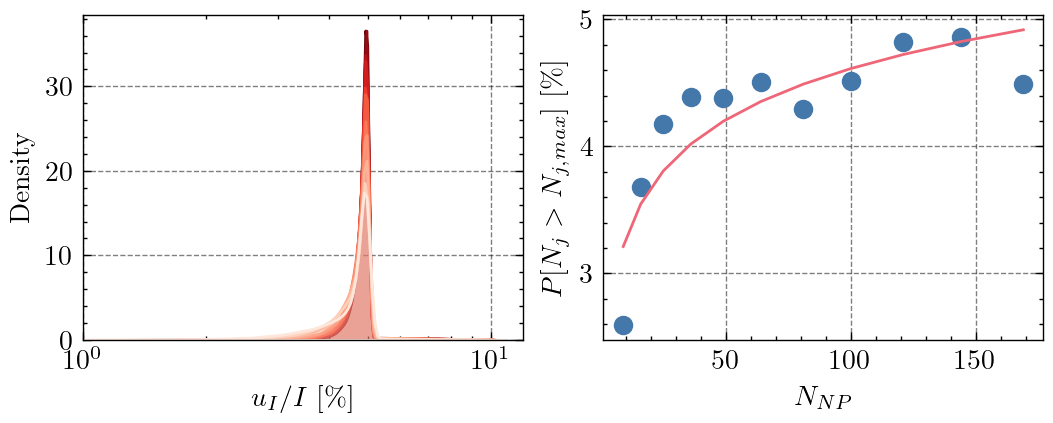

In [22]:
def lin_func(x, a, b):
    return a*x + b
def log_func(x, a, b):
    return a * np.log(x) + b

with plt.style.context(["science","bright","grid"]):

    cmap    = plt.get_cmap('Reds')
    fig     = plt.figure(dpi=200, layout='constrained')
    ax1     = fig.add_subplot(1,2,1)
    ax2     = fig.add_subplot(1,2,2)
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*0.8)

    for i, arr in enumerate(rel_error_dist[::-1]):
        arr1            = arr.copy()
        arr1[arr1 > 10] = 10
        ax1             = sns.kdeplot(arr1, ax=ax1, color=cmap((len(rel_error_dist)-i)/len(rel_error_dist)), 
                                      fill=True, alpha=0.1, log_scale=True)

    ax1.set_xlim(1,12)
    ax1.set_xlabel('$u_I / I$ [\%]')

    x       = np.array(N_vals)**2
    y       = max_jumps_portion
    p, _    = curve_fit(log_func, x, y)
    ax2.plot(x, y, 'o')
    ax2.plot(x, log_func(x,*p), '-')
    ax2.set_xlabel('$N_{NP}$')
    ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
    # ax2.set_xlim(0,270)

    # fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
    # fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')

In [2]:
from nanonets import Simulation
from nanonets.utils import display_network

N_vals = [9]
for n in N_vals:
        topo = {"Nx": n, "Ny": n,
                "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                        [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
                "electrode_type" : ['constant']*8}
        sim_class = Simulation(topo, pack_optimizer=False)

        fig, ax = plt.subplots(dpi=200)
        fig, ax = display_network(sim_class.get_graph(), sim_class.get_positions(), sim_class.get_radius(), fig, ax)
        ax.axis('off')
        # fig.savefig(f"plots/system_size/network_plots/N{n}_N{n}.svg", transparent=True)
        # plt.close(fig)

NameError: name 'plt' is not defined

In [3]:
sim_class.get_capacitance_matrix()

array([[34.1925675 , -2.55593674, -0.73584461, ..., -0.13807119,
        -0.1298522 , -0.1219777 ],
       [-2.55593674, 37.13001551, -2.55593674, ..., -0.14639669,
        -0.13807119, -0.1298522 ],
       [-0.73584461, -2.55593674, 38.98804356, ..., -0.15445694,
        -0.14639669, -0.13807119],
       ...,
       [-0.13807119, -0.14639669, -0.15445694, ..., 38.98804356,
        -2.55593674, -0.73584461],
       [-0.1298522 , -0.13807119, -0.14639669, ..., -2.55593674,
        37.13001551, -2.55593674],
       [-0.1219777 , -0.1298522 , -0.13807119, ..., -0.73584461,
        -2.55593674, 34.1925675 ]])